<a href="https://colab.research.google.com/github/JoseReveco/MinorMachineLearning/blob/main/Proyecto%20Final%20ML/%20Entrega%2003%20-%20Explore/%20Entrega_03_Explore_Plantilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proyecto Final - Reconocimiento de Actividad Humana (HAR)





###OBTAIN


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.manifold import TSNE

from google.colab import drive

In [146]:

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt'
# Agregamos una columna demas debido a que algunas filas del dataset poseen un campo vacio extra ( un septimo), luego la eliminamos.
data = pd.read_csv(path, header=None, names=["user", "activity" ,"timestamp", "x-acceleration", "y-accel", "z-accel", "del"])
data = data.drop('del', axis=1)
# Panda toma el ; al final de cada fila, lo eliminamos con:
data["z-accel"] = data["z-accel"].str[:-1]
df = pd.DataFrame(data = data)
df.count(axis=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


user              1098204
activity          1098204
timestamp         1098204
x-acceleration    1098204
y-accel           1098204
z-accel           1098203
dtype: int64

###SCRUB

Eliminar filas con datos faltantes

*Uno de los pasos iniciales en la limpieza de datos consiste en eliminar aquellas filas que contengan datos faltantes. Estas líneas generalmente no aportan información y pueden complicar la etapa de entrenamiento y validación de muchos modelos predictivos.*

In [147]:
# Quitamos los datos faltantes con dropna, luego contamos las filas con count(axis=0)
df = df.dropna()
df.count(axis=0)

user              1098203
activity          1098203
timestamp         1098203
x-acceleration    1098203
y-accel           1098203
z-accel           1098203
dtype: int64

Agregar al DataFrame los nombres de las columnas 

*En ocasiones al crear los data frames el sistema asigna nombres genéricos y correlativos a las columnas. Es recomendable renombrar las columnas por nombres significativos para favorecer el análisis posterior de los datos.*

In [148]:
# Le cambiamos los nombres a las columnas para que queden con el formato pedido
df = df.rename(columns={'user':'user','activity':'activity', 'timestamp':'time', 'x-acceleration':'x', 'y-accel':'y', 'z-accel':'z'})

Visualizar las 5 primeras filas del DataFrame (.head())

*Siempre es buena medida visualizar algunas líneas del dataframe para tener una idea concreta del contenido.*

In [149]:
# Mostramos las 5 primeras filas
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


Buscar datos nulos y eliminarlos si es que existen

In [150]:
#buscar nulos, nos da todos falsos
df.isnull().any()

user        False
activity    False
time        False
x           False
y           False
z           False
dtype: bool

Visualizar los tipo de datos a los que pertenece cada columna (.info())

*Es necesario tener un detalle de cuantas variables están considerando y el tipo de datos que pertenecen para verificar si es posible utilizarla directamente para el modelo predictivo o si es necesario realizar una transformación del tipo de dato.*

In [151]:
# Mostramos la informacion del df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   user      1098203 non-null  int64  
 1   activity  1098203 non-null  object 
 2   time      1098203 non-null  int64  
 3   x         1098203 non-null  float64
 4   y         1098203 non-null  float64
 5   z         1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 58.7+ MB


Cambiar el tipo de datos de las variables predictoras a valores reales, para realizar la clasificación 

*Muchas de las variables contenidas en el DataFrame originalmente se encuentran en el tipo de dato 'object'. En ese formato las variables no pueden ser interpretadas como vectores. Recordemos que la mayoría de los modelos de Machine Learning estudiados operan en el espacio vectorial. Por esta razón las variables que formarán parte del modelo predictivo deben ser transformadas a un formato numérico como 'Float' o 'integer'.*

Para este proyecto en particular se pide transformar al tipo de dato Float, las variables del acelerómetro en el eje x, y y z




In [152]:
# Al intentar hacer la transformacion nos da el siguiente error:
# df[['x', 'y', 'z']] = df[['x', 'y', 'z']].apply(pd.to_numeric)

In [153]:
# Los datos vienen con errores, los corregiriemos:
# Para esto pasamos la columna z a String
df['z'] = df['z'].astype(str)
# Ahora que es un String buscamos todas las filas que poseen ";" en la columna z. 
mask = df.z.apply(lambda x: ';' in x)
df1 = df[mask]
df1.head()
# Estas filas son las que nos darán error:

,user,activity,time,x,y,z
134633,13,Downstairs,3498732310000,5.13,10.42,4.671779;1
197686,27,Jogging,10814072309000,4.21,-0.65,-0.6537767;2
273260,18,Jogging,0,0.00,0.00,0.0;1
371928,16,Downstairs,7160742320000,4.79,7.31,-4.0588636;
711479,30,Standing,1729732341000,-1.80,9.28,3.79;3


In [154]:
# Las modificamos con:
df.loc[134633,'z'] = 4.671779
df.loc[197686,'z'] = -0.6537767
df.loc[273260,'z'] = 0.0
df.loc[371928,'z'] = -4.0588636
df.loc[711479,'z'] = 3.79

# Y hacemos la conversión nuevamente con:
df[['x', 'y', 'z']] = df[['x', 'y', 'z']].apply(pd.to_numeric)

Imprimir los tipos de datos de las variables del DataFrame

*Se recomienda volver a ejecutar el comando info para verificar que efectivamente las variables cambiaron su tipo de dato y que ahora se pueden procesar con los modelos predictivos.*

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   user      1098203 non-null  int64  
 1   activity  1098203 non-null  object 
 2   time      1098203 non-null  int64  
 3   x         1098203 non-null  float64
 4   y         1098203 non-null  float64
 5   z         1098152 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


Eliminar las columnas que no se utilizaran para la clasificación

*En este caso deberíamos conservar la actividad respectiva y las variables asociadas al acelerómetro*

In [156]:
# Eliminamos las columnas user y time con drop
df = df.drop(['user', 'time'], axis=1)


Utilizar el comando value_counts para obtener un detalle de cuantas instancias se tienen por actividad. El objetivo consiste en identificar la presencia del balance o desbalance en las categorías a modelar

In [157]:
# Usamos value_counts para ver cuantos tipos existen en la columna activity
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

Este proyecto considera datos con un desbalance de clases. Es necesario balancearlos para que los modelos operen de manera adecuada. Existen muchas maneras de realizar un balance, pero en este proyecto utilizaremos una estrategia sencilla e intuitiva. Simplemente debe identificar la actividad que contenga el número menor de instancias. Se debe realizar un muestreo para las otras actividades utilizando ese valor. De esta manera todas las clases tendrán la misma cantidad de instancias. 

In [158]:
# Balanceamos la columna recorriendo cada tipo de actividad y haciendo un sample con la cantidad menor
df = df.groupby('activity', as_index=False).apply(lambda x: x.sample(n=48395)).reset_index(drop=True)

Establecer el número de instancias y dimensiones del data frame resultante *(shape)*

In [159]:
# Realizamos el shape para comprobar que vamos bien.
df.shape

(290370, 4)

Volver a imprimir la cantidad de instancias por categoría para verificar que todo esté en orden. (value_counts)

In [160]:
# Comprobamos el balanceo
df['activity'].value_counts()

Downstairs    48395
Jogging       48395
Sitting       48395
Standing      48395
Upstairs      48395
Walking       48395
Name: activity, dtype: int64

Volver a visualizar las cinco primeras líneas del DataFrame para revisar que todo esté en orden (head)

In [161]:
# Nuevamente usamos head
df.head()

,activity,x,y,z
0,Downstairs,9.23,7.06,1.040000
1,Downstairs,0.53,7.93,0.610000
2,Downstairs,0.80,9.62,0.994285
3,Downstairs,-4.06,10.23,-0.994285
4,Downstairs,-2.22,7.46,-2.790000


Separar las variables predictoras (X) de las categorias o etiquetas (y)

In [162]:
# Las predictoras son las x, y, z y las etiquetas son las actividades

X = df[["x", "y", "z"]]
y = df['activity']
X.head()

,x,y,z
0,9.23,7.06,1.040000
1,0.53,7.93,0.610000
2,0.80,9.62,0.994285
3,-4.06,10.23,-0.994285
4,-2.22,7.46,-2.790000


Estandarizar los datos numericos (StandardScaler)

*Para el caso de la estandarización de los datos se pueden usar distintas técnicas, como la normalización 01, estandarización entre -1 y 1 o el denominado Z-Score. En este caso usaremos la función Standard Scaler de Python con sus valores por defecto.*

In [163]:
# Utilizamos StandarScaler para transformar los valores de X
scaled_features = StandardScaler().fit_transform(X.values)
# Los transformamos a un DataFrame, le damos los mismos nombres a las columnas usando columns e index, igualandolo a X.
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
scaled_features_df.head()

,x,y,z
0,1.474123,0.018969,-0.061844
1,0.009611,0.166137,-0.155826
2,0.055062,0.452014,-0.071836
3,-0.763045,0.555200,-0.506463
4,-0.453309,0.086632,-0.898938


Como último paso debe reconstruir el dataframe pegando las columnas de los variables predicadores (X) y las categorías (y)

In [164]:
#Unimos ambos df con concat, utilizando un inner join.
df_final = pd.concat([y, scaled_features_df], axis=1, join='inner')
df_final.head()

,activity,x,y,z
0,Downstairs,1.474123,0.018969,-0.061844
1,Downstairs,0.009611,0.166137,-0.155826
2,Downstairs,0.055062,0.452014,-0.071836
3,Downstairs,-0.763045,0.555200,-0.506463
4,Downstairs,-0.453309,0.086632,-0.898938


Referencias:
1. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
2. https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
3. https://stackoverflow.com/questions/22005911/convert-columns-to-string-in-pandas
4. https://www.analyticslane.com/2019/03/25/como-eliminar-columnas-y-filas-en-un-dataframe-pandas/
5. https://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column
6. https://stackoverflow.com/questions/52935324/make-dataframe-balanced-with-respect-to-a-specific-column
7. https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
8. https://www.geeksforgeeks.org/how-to-combine-two-dataframe-in-python-pandas/

###EXPLORE

Comprobación de desequilibrios de datos:

**- El desbalance se provoca cuando:** En problemas de clasificación entre las múltiples categorías (de training) solemos encontrar que alguna de ellas presenta pocas muestras. Esto provoca un desbalanceo en los datos que utilizaremos para el entrenamiento. 

**- Cómo afectan los datos desbalanceados:**  Por lo general afecta a los algoritmos y perjudican a las clases minoritarias.Por ejemplo: si a una red neuronal le damos 990 de fotos de gatos y sólo 10 de perros, no podemos pretender que logre diferenciar una clase de otra. Lo más probable que la red se limite a responder “tu foto es un gato” puesto que así tuvo un acierto del 99% en su fase de entrenamiento.

Si sólo tenemos en cuenta a la clase mayoritaria podemos estar teniendo una 'falsa' sensación de que el modelo funciona bien. Cuando tenemos un dataset con desequilibrio, suele ocurrir que obtenemos un alto valor de Accuracy en la clase Mayoritaria y un bajo Recall en la clase Minoritaria

La finalidad de balancear los datos es para evitar una predicción erronea

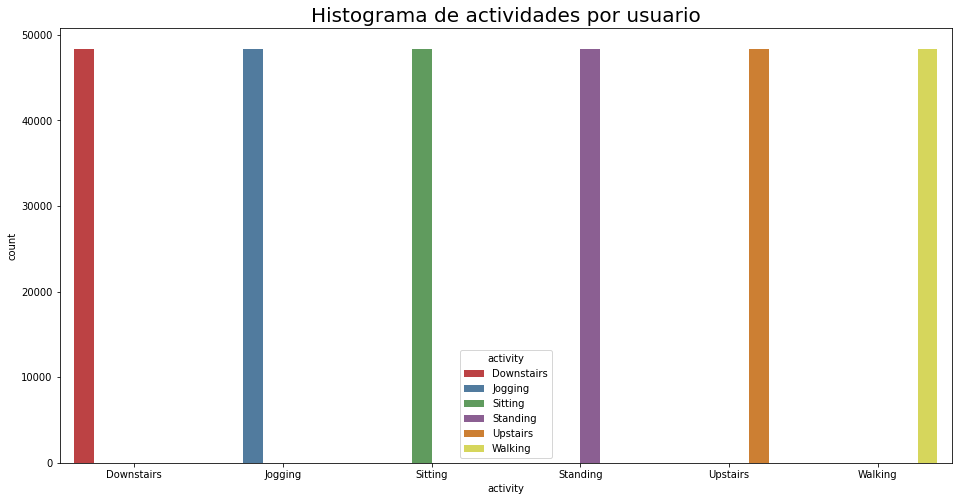

In [165]:
plt.figure(figsize=(16,8))
plt.title('Histograma de actividades por usuario', fontsize=20)
sns.countplot(x='activity',hue='activity', data = df_final)
plt.show()



En esta FIGURA se pueden visualizar un hitograma donde en el eje $x$ se encuentran los 30 individuos, especificando las 6 actividades que realizaron cada uno. Mientras que en el eje $y$ se visualiza el total de instancias ejecutadas por actividad. 

Cada individuo realiza 6 actividades, donde se muestra en el mismo orden cada una de las actividades. Los nombres de las personas permanece anónimo, en su lugar se reemplaza un número identificador.

Las actividades ejecutadas en este caso fueron: 'pararse', 'sentarse', 'acostarse', 'caminar', 'bajar escaleras' y 'subir escaleras'.

***Como se muestra en la FIGURA ANTERIOR, se puede encontrar que los datos son seudo equilibrados, lo que indica que el conjunto de datos puede ser adecuado para el desarrollo de este proyecto.***

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


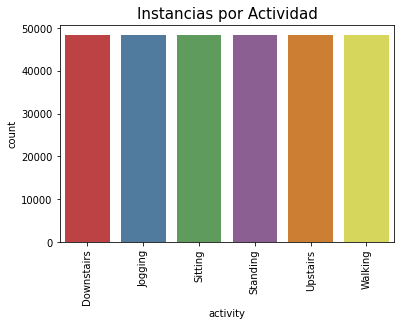

In [166]:
plt.title('Instancias por Actividad', fontsize=15)
sns.countplot(df_final.activity)
plt.xticks(rotation=90)
plt.show()

In [167]:
df_final.activity.value_counts()

Downstairs    48395
Jogging       48395
Sitting       48395
Standing      48395
Upstairs      48395
Walking       48395
Name: activity, dtype: int64

Con este histograma también se puede representar la cantidad de instancias que ocurre cada actividad, donde en el eje $x$ se encuentran las 6 actividades realizadas con barras de difenrente color, mientras que en el eje $y$ dr visualiza la cantidad total de muestras. 

Este histograma a diferencia del anterior no hace diferencia entre usuarios, simplemente se enfoca en la actividad y su cantidad.

In [168]:
df_final.columns

Index(['activity', 'x', 'y', 'z'], dtype='object')

In [169]:
columns = df_final.columns

# Reemplaza '()', '-' y ',' de los nombres de las columnas
columns = columns.str.replace('activity','activity')
columns = columns.str.replace('x', 'x')
columns = columns.str.replace('y','y')
columns = columns.str.replace('z','z')
df_final.columns = columns
df_final.columns = columns
df_final.columns

Index(['activity', 'x', 'y', 'z'], dtype='object')

**Visualización columna: x (x-acceleration)**


In [170]:
len(df_final.x)

290370

In [171]:
df_final.x.head(n=15)

0     1.474123
1     0.009611
2     0.055062
3    -0.763045
4    -0.453309
5    -0.581244
6    -0.104856
7     1.307472
8     0.494415
9     0.371531
10   -0.168824
11   -2.847028
12    0.895052
13    1.990911
14   -0.143573
Name: x, dtype: float64

(array([ 4270.,  3778.,  9995., 37518., 96249., 69531., 41635., 17609.,
         5445.,  4340.]),
 array([-3.38064942, -2.71471738, -2.04878534, -1.3828533 , -0.71692126,
        -0.05098922,  0.61494281,  1.28087485,  1.94680689,  2.61273893,
         3.27867097]),
 <a list of 10 Patch objects>)

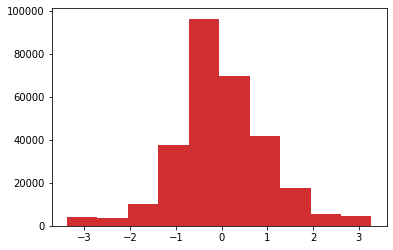

In [172]:
plt.hist(df_final.x)

El histograma de frecuencia es un gráfico que se usa para presentar las frecuencias absolutas de los valores de una distribución en el cual la altura del punto asociado a un valor de las variables es proporcional a la frecuencia de dicho valor.

A diferencia de un gráfico de barra, el histograma de frecuencia los rangos en el eje $x$ son continuos. Por esta razón se debe determinar un tamaño del bin que denota un rango de los elementos para esa barra en particular. La altura de la barra determina la cantidad de veces que se repite la ocurrencia de los valores en ese rango. A mayor distancia o longitud de la barra mayor repetición del elemento en particular.

Éste gráfico se construye fusionando todas las actividades de todos los individuos registrados en el conjunto de datos. El objetivo es conocer la distribución de datos que rige a las actividades. En este caso estamos poniendo atención en el valor del acelerómetro. Podríamos concluir otro histograma focalizándonos en otra variable. 

Enfocados en este gráfico se puede visualizar que en el eje $x$ estan los valores capturados por el acelerómetros y en el eje $y$ la suma de instancias que se encuentra por cada valor de medición.

Por otro lado al construir un histograma pero esta vez separando las actividades podemos ver diferencias en la distribución de los datos, lo que puede entregar luces respecto a diferencias en los patrones de la acelerómetro para diferenciar entre actividades.

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplo

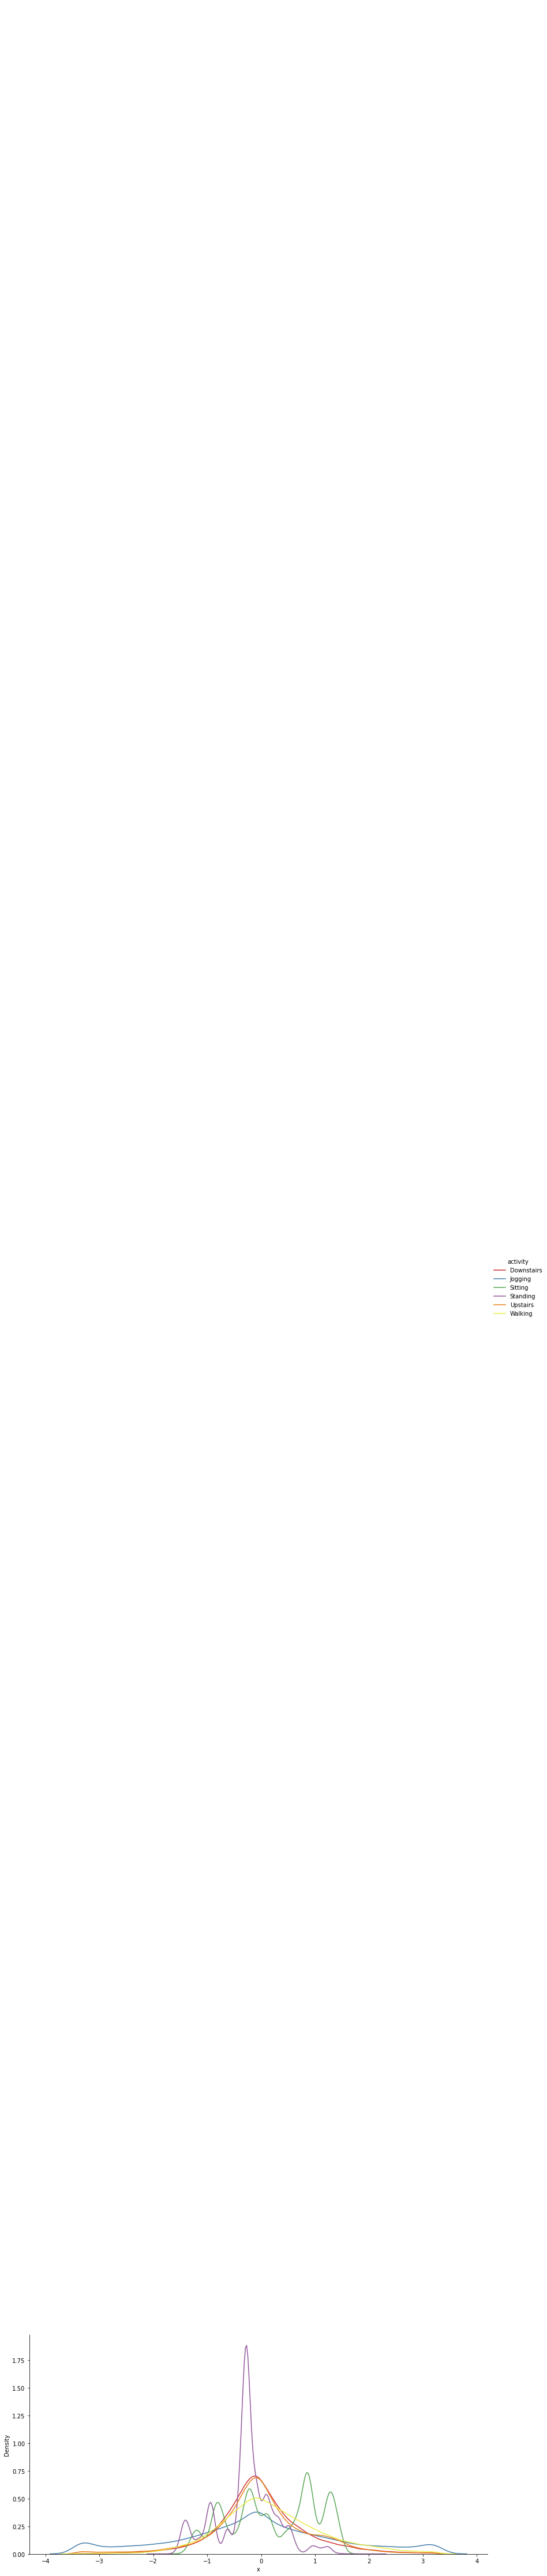

In [173]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(df_final, hue='activity', size=6,aspect=2)
facetgrid.map(sns.distplot,'x', hist=False)\
    .add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,17), xytext=(-0.9, 23), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()


El siguiente gráfico muestra un histograma para cada una de las seis actividades. En vez de mostrar barras se muestra un suavizado de la curva para tener una idea de la distribución de los datos. Cada color representa una actividad y que está indica en la leyenda. Del gráfico se puede inferir que existen distintos patrones gobernando las distintas actividades. Por ejemplo entre los valores 2 y 4 prácticamente no está presente la señal verde que corresponde a la actividad de permanecer sentado. Sin embargo en ese mismo rango se registra una presencia de las actividades caminar, trotar y subir escaleras.

Éstas diferencias en el histograma pueden ser clave para determinar que efectivamente es posible encontrar patrones que distingan entre una actividad y otra.

En este caso solamente estamos considerando una dimensión, entonces es posible hipotetizar que al considerar más de una variable de manera simultánea la distinción será aún más marcada. ('x')

En la parte central del histograma coincide que se encuentran las actividades que involucran el movimiento humano como caminar subir y bajar escaleras y que están indicadas con una flecha roja.


***Sobre la base de los datos dados, se dibujan los gráficos de seis estados activos, como se muestra en la FIGURA ANTERIOR.***

In [174]:
# para fines de trazado, llevar puntos de datos de cada actividad a un marco de datos diferente
df1 = df_final[df_final['activity']=='Walking']
df2 = df_final[df_final['activity']=='Upstairs']
df3 = df_final[df_final['activity']=='Downstairs']
df4 = df_final[df_final['activity']=='Sitting']
df5 = df_final[df_final['activity']=='Standing']
df6 = df_final[df_final['activity']=='Jogging']

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

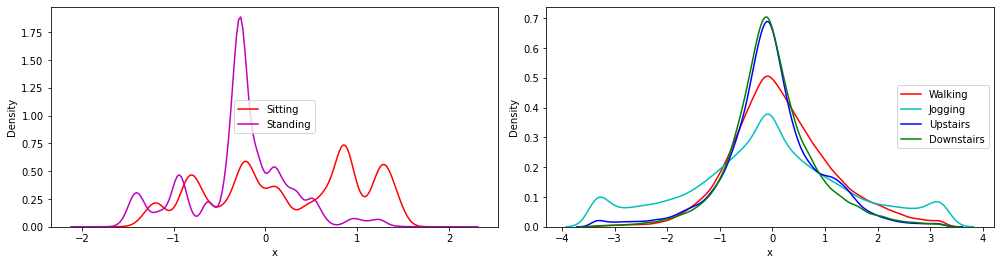

In [175]:
plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
sns.distplot(df4['x'],color = 'r',hist = False, label = 'Sitting')
sns.distplot(df5['x'],color = 'm',hist = False,label = 'Standing')
plt.legend(loc='center')

plt.subplot(2,2,2)
sns.distplot(df1['x'],color = 'red',hist = False, label = 'Walking')
sns.distplot(df6['x'],color = 'c',hist = False, label = 'Jogging')
sns.distplot(df2['x'],color = 'blue',hist = False,label = 'Upstairs')
sns.distplot(df3['x'],color = 'green',hist = False, label = 'Downstairs')
plt.legend(loc='center right')


plt.tight_layout()
plt.show()

Debido a los hallazgos obtenidos en los gráficos anteriores, se decide separar las actividades entre aquellas que involucran el movimiento humano de aquellas en donde el individuo permanece estático. En este caso las actividades dinámicas corresponden a tres y también las actividades estáticas son tres.

Las actividades dinámicas involucran 'caminar', 'subir escaleras', 'bajar escaleras' y 'trotar'. Mientras que las actividades estáticas consideran permanecer 'sentado' y estar 'de pie'.
Observé que los rangos en histograma dónde se marca la presencia de la actividades dinámicas y estáticas son distintas.

Si consideramos solamente las actividades estáticas, dentro del rango -2,0 y -0,5 es posible establecer diferencias en los patrones. Análogamente entre los rangos 2 y 4 es posible percibir diferencias en los valores del acelerometro para las actividades dinámicas.

Si tuviéramos que realizar un clasificador basándonos solamente en esta variable, ya podríamos tener resultados con cierto nivel de certeza dado que visualmente logramos ver las diferencias en los patrones.

Considerando también las diferencias en las otras variables en la construcción del clasificador uno esperaría mejores niveles de reconocimiento.

Otro elemento que llama la atención es que las seis curvas formadas tienen una forma parecida a una distribución normal.

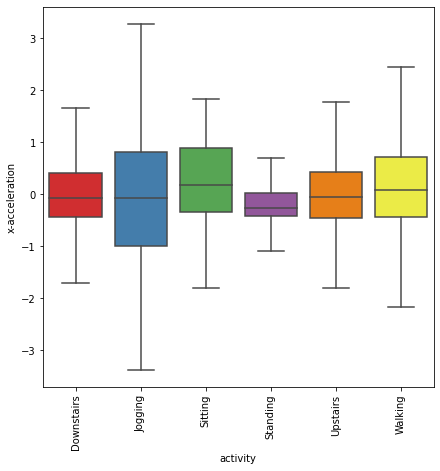

In [176]:
plt.figure(figsize=(7,7))
sns.boxplot(x='activity', y='x',data=df_final, showfliers=False, saturation=1)
plt.ylabel('x-acceleration')
plt.xticks(rotation=90)
plt.show()

Otra perspectiva de los datos consiste en la construcción de diagramas de caja. En este caso se construyeron “boxplot”  para cada una de las seis actividades considerando la misma medida de la acelerómetro utilizada en los histogramas anteriores. La magnitud de una aceleración puede separar los boxplot, identificando:

1. Si tAccMean es < 0, entonces las actividades son de bajar las escaleras, trotar, estar trotar y estar parado.

2. Si tAccMean es >= 0 , entonces las actividades son estar sentando, subir escaleras y mcaminar.

3. La que presenta una menor tAccMean para x-acceleration es estar de pie.

4. La que presenta una mayor tAccMean para x-acceleration es estar de sentado.

Los histograma confirman la diferencia entre las actividades llamadas estáticas y las dinámicas. 

Focalizándonos en las actividades dinámicas vemos también una notoria diferencia en las medias.

Para el caso de las actividades estáticas las diferencias son menos claras.Intuitivamente da la impresión que diferenciar las actividades estáticas basándonos exclusivamente en la información de la acelerómetro es una tarea difícil.

También aparece claro que diferenciar entre una actividad estática y dinámica y sencillo a partir de la información de la información del  acelerometrometro.


**Visualización columna: y (y-acceleration)**

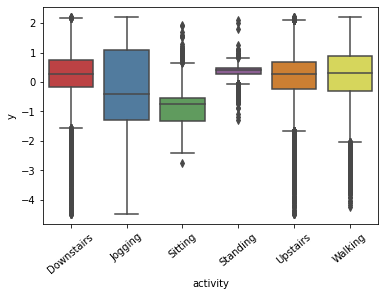

In [178]:
sns.boxplot(x='activity', y='y', data=df_final)
plt.xticks(rotation = 40)
plt.show()


También se puede trabajar con el componente de aceleracion en el eje y, en este caso porque se tienen los datos disponibles. 

Aquí ver un boxplot donde si angleX, y-accelMean > 0.0, la acción en progreso es 'bajar escaleras', 'estar de pie', 'subir escaleras' y 'caminar'

Este proceso también se realiza para el eje de $x$ (x-accelMean) y $z$ (z-accelMean) que es el último que nos falta.


**Visualización columna: z (z-acceleration)**

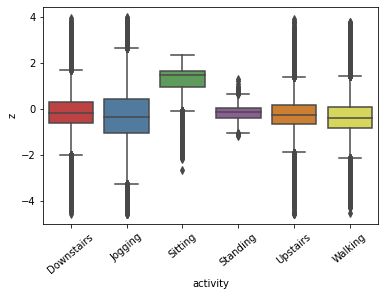

In [179]:
sns.boxplot(x='activity', y='z', data=df_final)
plt.xticks(rotation = 40)
plt.show()

**Visualización columna: x (x-acceleration)**

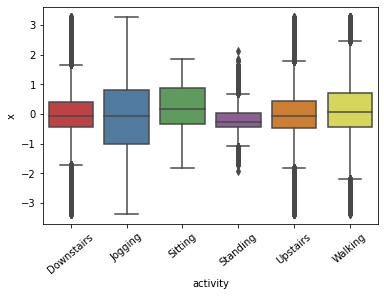

In [180]:
sns.boxplot(x='activity', y='x', data=df_final)
plt.xticks(rotation = 40)
plt.show()

**Aplicar t-sne en los datos**



T Distributed Stochastic Neighbor Embedding (t-SNE) es una técnica de reducción de dimensionalidad utilizada para visualizar conjuntos de datos de alta dimensión en espacios bidimensionales o tridimensionales de baja dimensión. En comparación con otros algoritmos de reducción de dimensionalidad (como PCA), t-SNE crea un espacio de características reducido, con muestras similares modeladas por puntos cercanos y muestras diferentes modeladas por puntos distantes de alta probabilidad.

t-SNE integra la reducción de dimensionalidad y la visualización. 


**En la siguientes gráficas se utiliza t-SNE, con perplexity: 2, 5, 10, 20, 50 respectivamente, y el número máximo de iteraciones (100).**

In [187]:
# realiza t-sne con diferentes valores de perplejidad y sus respectivas tramas..

def perform_tsne(X_data, y_data, perplexities, n_iter=50, img_name_prefix='t-sne'):
        
    for index,perplexity in enumerate(perplexities):
        # realizar t-sne
        print('\nperforming tsne with perplexity {} and with {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity, n_jobs=-1).fit_transform(X_data)
        print('Done..')
        
        # preparar los datos para seaborn         
        print('Creating plot for this t-sne visualization..')
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
        
        # dibujar la trama en el lugar apropiado en la cuadrícula
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,\
                   palette="Set1",markers=['^','v','s','o', '1','2'])
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('saving this plot as image in present working directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')


performing tsne with perplexity 2 and with 50 iterations at max
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 290370 samples in 0.123s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 290370 samples in 3.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 290370
[t-SNE] Computed conditional probabilities for sample 2000 / 290370
[t-SNE] Computed conditional probabilities for sample 3000 / 290370
[t-SNE] Computed conditional probabilities for sample 4000 / 290370
[t-SNE] Computed conditional probabilities for sample 5000 / 290370
[t-SNE] Computed conditional probabilities for sample 6000 / 290370
[t-SNE] Computed conditional probabilities for sample 7000 / 290370
[t-SNE] Computed conditional probabilities for sample 8000 / 290370
[t-SNE] Computed conditional probabilities for sample 9000 / 290370
[t-SNE] Computed conditional probabilities for sample 10000 / 290370
[t-SNE] Computed conditional probabilities for sample 11000 / 290370
[t-SNE] Computed conditional probabilities for sample 12000 / 290370
[t-SNE] Computed conditional probabilities for sample 13000 / 290370
[t-SNE] Computed conditional probabilities for sample

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


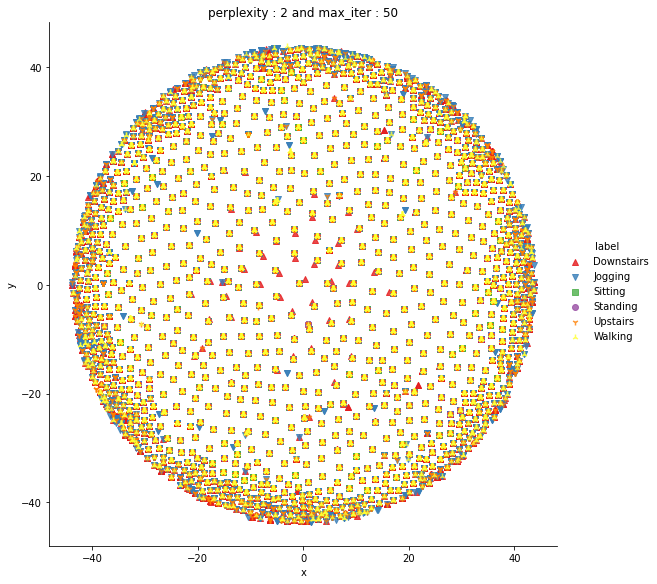

Done

performing tsne with perplexity 5 and with 50 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 290370 samples in 0.131s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 290370 samples in 3.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 290370
[t-SNE] Computed conditional probabilities for sample 2000 / 290370
[t-SNE] Computed conditional probabilities for sample 3000 / 290370
[t-SNE] Computed conditional probabilities for sample 4000 / 290370
[t-SNE] Computed conditional probabilities for sample 5000 / 290370
[t-SNE] Computed conditional probabilities for sample 6000 / 290370
[t-SNE] Computed conditional probabilities for sample 7000 / 290370
[t-SNE] Computed conditional probabilities for sample 8000 / 290370
[t-SNE] Computed conditional probabilities for sample 9000 / 290370
[t-SNE] Computed conditional probabilities for sample 10000 / 290370
[t-SNE] Computed conditional probabilities for sample 11000 / 290370
[t-SNE] Computed conditional probabilities for sample 12000 / 290370
[t-SNE] Computed conditional probabilities for sample 13000 / 290370
[t-SNE] Computed conditional probabilities for sample

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


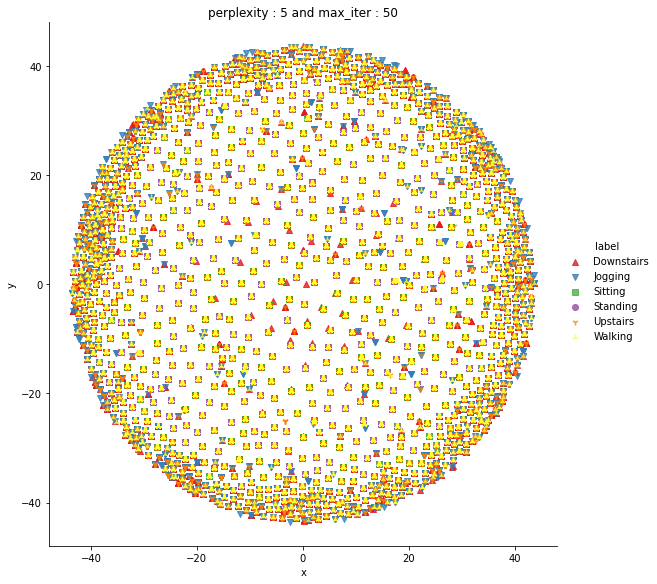

Done

performing tsne with perplexity 10 and with 50 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 290370 samples in 0.163s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 290370 samples in 4.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 290370
[t-SNE] Computed conditional probabilities for sample 2000 / 290370
[t-SNE] Computed conditional probabilities for sample 3000 / 290370
[t-SNE] Computed conditional probabilities for sample 4000 / 290370
[t-SNE] Computed conditional probabilities for sample 5000 / 290370
[t-SNE] Computed conditional probabilities for sample 6000 / 290370
[t-SNE] Computed conditional probabilities for sample 7000 / 290370
[t-SNE] Computed conditional probabilities for sample 8000 / 290370
[t-SNE] Computed conditional probabilities for sample 9000 / 290370
[t-SNE] Computed conditional probabilities for sample 10000 / 290370
[t-SNE] Computed conditional probabilities for sample 11000 / 290370
[t-SNE] Computed conditional probabilities for sample 12000 / 290370
[t-SNE] Computed conditional probabilities for sample 13000 / 290370
[t-SNE] Computed conditional probabilities for sample

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


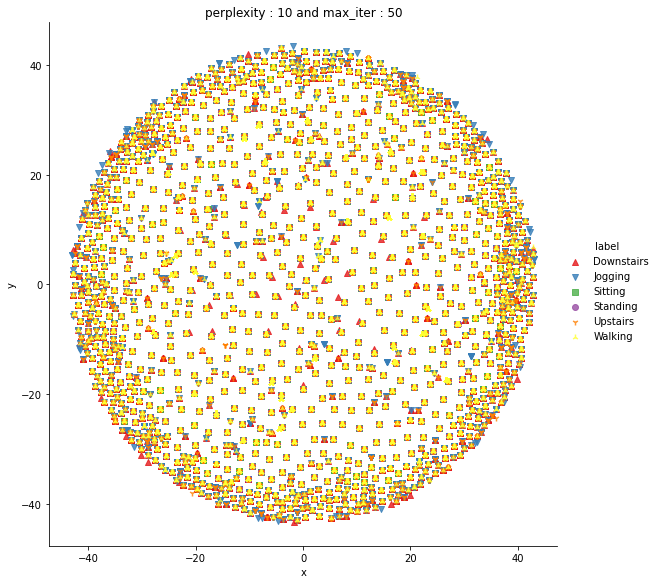

Done

performing tsne with perplexity 20 and with 50 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 290370 samples in 0.132s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 290370 samples in 4.939s...
[t-SNE] Computed conditional probabilities for sample 1000 / 290370
[t-SNE] Computed conditional probabilities for sample 2000 / 290370
[t-SNE] Computed conditional probabilities for sample 3000 / 290370
[t-SNE] Computed conditional probabilities for sample 4000 / 290370
[t-SNE] Computed conditional probabilities for sample 5000 / 290370
[t-SNE] Computed conditional probabilities for sample 6000 / 290370
[t-SNE] Computed conditional probabilities for sample 7000 / 290370
[t-SNE] Computed conditional probabilities for sample 8000 / 290370
[t-SNE] Computed conditional probabilities for sample 9000 / 290370
[t-SNE] Computed conditional probabilities for sample 10000 / 290370
[t-SNE] Computed conditional probabilities for sample 11000 / 290370
[t-SNE] Computed conditional probabilities for sample 12000 / 290370
[t-SNE] Computed conditional probabilities for sample 13000 / 290370
[t-SNE] Computed conditional probabilities for sample

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


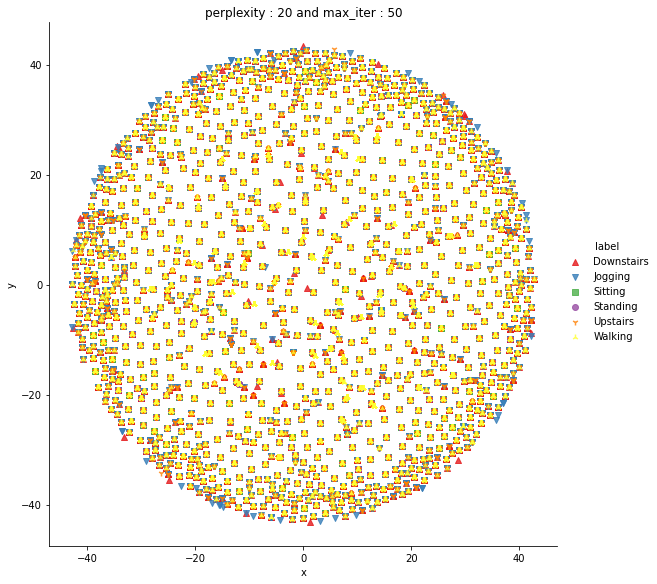

Done

performing tsne with perplexity 50 and with 50 iterations at max
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 290370 samples in 0.138s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 290370 samples in 10.985s...
[t-SNE] Computed conditional probabilities for sample 1000 / 290370
[t-SNE] Computed conditional probabilities for sample 2000 / 290370
[t-SNE] Computed conditional probabilities for sample 3000 / 290370
[t-SNE] Computed conditional probabilities for sample 4000 / 290370
[t-SNE] Computed conditional probabilities for sample 5000 / 290370
[t-SNE] Computed conditional probabilities for sample 6000 / 290370
[t-SNE] Computed conditional probabilities for sample 7000 / 290370
[t-SNE] Computed conditional probabilities for sample 8000 / 290370
[t-SNE] Computed conditional probabilities for sample 9000 / 290370
[t-SNE] Computed conditional probabilities for sample 10000 / 290370
[t-SNE] Computed conditional probabilities for sample 11000 / 290370
[t-SNE] Computed conditional probabilities for sample 12000 / 290370
[t-SNE] Computed conditional probabilities for sample 13000 / 290370
[t-SNE] Computed conditional probabilities for sampl

/usr/local/lib/python3.8/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


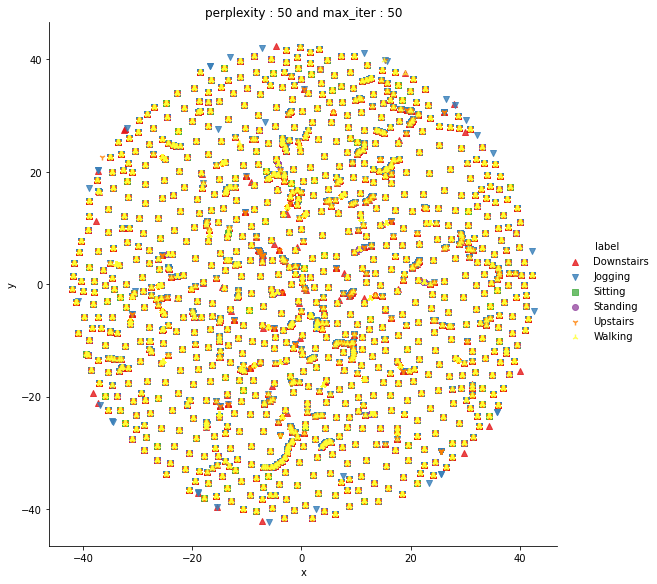

Done


In [188]:
X_pre_tsne = df_final.drop(['activity', 'y','z'], axis=1)
y_pre_tsne = df_final['activity']
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[2,5,10,20,50])